# 트랜스포머 모델 기반 한국어 챗봇 만들기

**진행 단계:**
1. **모델 구성요소 정의**: 어텐션, 인코더, 디코더 등 모델 각 부분 코드 구현
2. **데이터 준비 및 토크나이저**: 챗봇 데이터 전처리, SentencePiece 이용한 토크나이저를 학습
3. **데이터셋 및 데이터로더 구축**: PyTorch Dataset 및 DataLoader 생성
4. **모델 학습**: 정의한 모델과 데이터로더를 이용한 학습 진행, 검증 데이터셋으로 성능 측정
5. **챗봇 성능 테스트 (추론)**: 학습된 모델로 새로운 문장에 대한 답변을 생성, 다양한 디코딩 전략을 비교

**오늘의 회고:**
1. LMS에서 기본 블럭들은 다 제공해줘서 조합정도만 했지만 이것저것 보면서 트랜스포머 모델을 만져본건 재밋었다.
2. 확실히 에폭이 늘수록 로스는 줄기는 하지만 데이터 양이 절대적으로 부족해서 인지 학습을 많이 늘리더라도 비약적인 성능의 향상은 없었다.
3. 디코딩 전략에 따라 같은 모델로도 다양한 결과? 가 나오는게 신기한 점

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import csv
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt

## 1. 모델 구성요소 정의

In [2]:
# 단어의 순서 정보를 모델에 알려주기 위한 클래스
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        # 입력 텐서(x)에 위치 정보를 더해 반환
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

In [3]:
# 어텐션
def scaled_dot_product_attention(query, key, value, mask=None):
    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) key의 차원 수(depth)의 제곱근으로 나누어 스케일링
    depth = key.size(-1)
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스킹: 어텐션에서 특정 토큰을 무시하도록 처리
    if mask is not None:
        logits = logits + (mask * -1e9) # 아주 작은 값을 더해 softmax 결과가 0이 되도록 함

    # 4) 소프트맥스 함수로 어텐션 가중치(확률 분포) 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) 어텐션 가중치와 V를 내적하여 최종 어텐션 값 계산
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [4]:
# 멀티 헤드 어텐션: 어텐션을 여러 번 수행하여 다른 관점의 정보를 종합하는 클래스
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0
        self.depth = d_model // num_heads

        # Q, K, V를 위한 Linear 레이어
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        # 최종 출력을 위한 Linear 레이어
        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        # d_model 차원을 num_heads와 depth로 분할
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 레이어 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 헤드 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 수행
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # 헤드 다시 합치기
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Linear 레이어 적용
        output = self.out_dense(concat_attention)
        return output

In [5]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [6]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [7]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2


In [8]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

In [9]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [10]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

## 2. 데이터 준비 및 토크나이저

In [11]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (한글, 알파벳, 숫자, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [12]:
# CSV 파일 읽어서 전처리 후, 텍스트 파일로 저장
input_file = 'data/ChatbotData.csv'
output_file = 'data/chatbot_corpus.txt'
with open(input_file, 'r', encoding='utf-8') as f_in, \
        open(output_file, 'w', encoding='utf-8') as f_out:

    reader = csv.reader(f_in)
    next(reader)  # 헤더 행 건너뛰기

    for row in reader:
        if len(row) > 1:
            question = row[0]
            answer = row[1]

            if question and isinstance(question, str):
                processed_q = preprocess_sentence(question)
                f_out.write(processed_q + "\n")
                count += 1

            if answer and isinstance(answer, str):
                processed_a = preprocess_sentence(answer)
                f_out.write(processed_a + "\n")

In [13]:
# 이전에 생성한 텍스트 파일 경로
corpus_file = '/Users/bychoi/develop/aiffel_quest_rs/Exploration/Ex07/data/chatbot_corpus.txt'

# SentencePiece 모델 학습
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix='spm_chatbot',
    vocab_size=8000,
    character_coverage=1.0,
    model_type='bpe',
    max_sentence_length=999999,
    bos_id=1,
    eos_id=2,
    pad_id=0,
    unk_id=3,
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /Users/bychoi/develop/aiffel_quest_rs/Exploration/Ex07/data/chatbot_corpus.txt
  input_format: 
  model_prefix: spm_chatbot
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad

 piece=▁받아들여야
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=6660 all=37381 active=1818 piece=▁세워보세요
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=6680 all=37361 active=1798 piece=▁연락하는게
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=6700 all=37342 active=1779 piece=▁정리하세요
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=4 min_freq=3
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=6720 all=37325 active=1851 piece=▁표현해보는
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=6740 all=37307 active=1833 piece=▁되짚어보세요
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=6760 all=37287 active=1813 piece=▁필요해보여요
trainer_interface.cc(687) LOG(INFO) Saving model: spm_chatbot.model
trainer_interface.cc(699) LOG(INFO) Saving vocabs: spm_chatbot.vocab


In [14]:
sp = spm.SentencePieceProcessor()
sp.Load("spm_chatbot.model")

True

In [15]:
# 예제 문장
sentence = "안녕하세요, 저는 챗봇입니다. 반갑습니다! 벌써 12시네요."

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)


전처리 후의 문장: 안녕하세요 , 저는 챗봇입니다 . 반갑습니다 ! 벌써 12시네요 .
Tokenized: ['▁안녕하세요', '▁,', '▁저는', '▁', '챗', '봇', '입니다', '▁.', '▁반갑', '습니다', '▁!', '▁벌써', '▁12', '시', '네요', '▁.']
Encoded: [4615, 422, 617, 6775, 7969, 7411, 405, 4, 4838, 151, 108, 1033, 5550, 6817, 33, 4]
Decoded: 안녕하세요 , 저는 챗봇입니다 . 반갑습니다 ! 벌써 12시네요 .


## 3. 데이터셋 및 데이터로더 구축

In [16]:
# Chatbot 데이터셋 클래스 정의
class ChatbotDataset(Dataset):
    def __init__(self, csv_file, sp_model, max_length=40):
        super().__init__()
        self.sp = sp_model
        self.max_length = max_length
        self.data = []

        # CSV 파일에서 (질문, 답변) 쌍을 읽어옵니다.
        with open(csv_file, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            next(reader)  # 헤더 행 건너뛰기
            pairs = [(row[0], row[1]) for row in reader]

        for q_text, a_text in pairs:
            # 1) SentencePiece 모델로 문장을 토큰 ID 배열로 변환
            q_ids = self.sp.EncodeAsIds(q_text)
            a_ids = self.sp.EncodeAsIds(a_text)

            # 2) 문장 시작/끝을 나타내는 스페셜 토큰 ID 추가
            bos_id = self.sp.bos_id()
            eos_id = self.sp.eos_id()
            pad_id = self.sp.pad_id()

            enc_input = [bos_id] + q_ids + [eos_id]
            dec_input = [bos_id] + a_ids
            target = a_ids + [eos_id]

            # 3) 최대 길이를 초과하는 샘플은 제외
            if len(enc_input) > max_length or len(target) > max_length:
                continue

            # 4) 패딩(Padding) 추가하여 모든 문장의 길이를 통일
            enc_input += [pad_id] * (max_length - len(enc_input))
            dec_input += [pad_id] * (max_length - len(dec_input))
            target += [pad_id] * (max_length - len(target))

            # 전처리 완료된 데이터를 self.data에 저장
            self.data.append({
                "enc_input": enc_input,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        # 데이터를 파이토치 텐서로 변환
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

--- 문장 길이 토큰 분포 통계 ---
최대 길이: 29
최소 길이: 1
평균 길이: 5.59
중앙값: 5.0
--------------------
90% 지점: 9.00
95% 지점: 10.00
99% 지점: 13.00
99.9% 지점: 19.00
--------------------


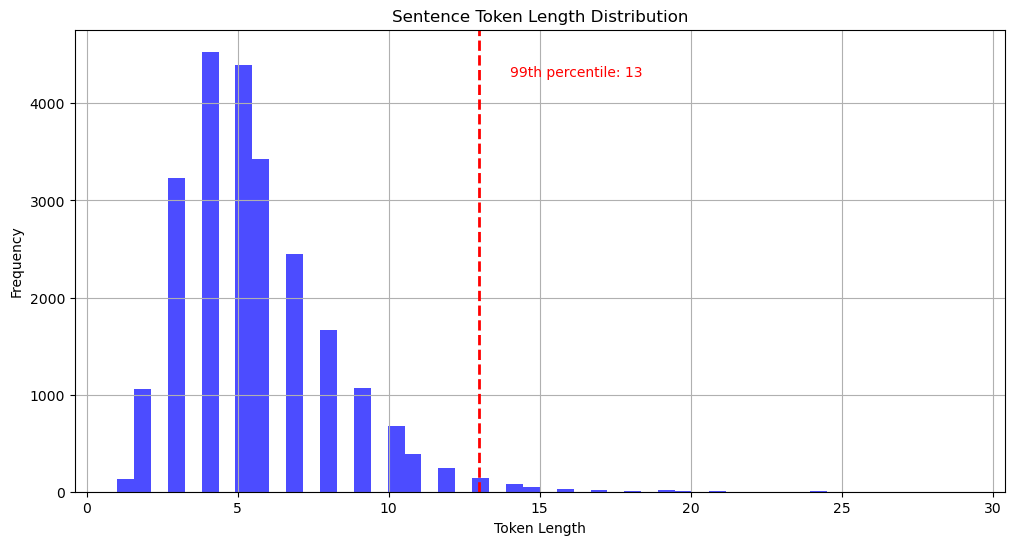

In [17]:
# CSV 파일을 읽어 모든 문장의 토큰 길이를 계산
csv_file_path = 'data/ChatbotData.csv'
token_lengths = []

with open(csv_file_path, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)  # 헤더 건너뛰기
    for row in reader:
        if len(row) > 1:
            # 질문과 답변 모두에 대해 처리
            for sentence in [row[0], row[1]]:
                if sentence and isinstance(sentence, str):
                    processed = preprocess_sentence(sentence)
                    ids = sp.EncodeAsIds(processed)
                    token_lengths.append(len(ids))

# 길이 분포 통계 계산
token_lengths = np.array(token_lengths)

print("--- 문장 길이 토큰 분포 통계 ---")
print(f"최대 길이: {np.max(token_lengths)}")
print(f"최소 길이: {np.min(token_lengths)}")
print(f"평균 길이: {np.mean(token_lengths):.2f}")
print(f"중앙값: {np.median(token_lengths)}")
print("-" * 20)
# 백분위수(Percentile) 계산
print(f"90% 지점: {np.percentile(token_lengths, 90):.2f}")
print(f"95% 지점: {np.percentile(token_lengths, 95):.2f}")
print(f"99% 지점: {np.percentile(token_lengths, 99):.2f}")
print(f"99.9% 지점: {np.percentile(token_lengths, 99.9):.2f}")
print("-" * 20)


# 히스토그램으로 시각화
plt.figure(figsize=(12, 6))
plt.hist(token_lengths, bins=50, alpha=0.7, color='blue')
plt.title('Sentence Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

# 99% 지점에 수직선 추가
percentile_99 = np.percentile(token_lengths, 99)
plt.axvline(percentile_99, color='red', linestyle='dashed', linewidth=2)
plt.text(percentile_99 + 1, plt.ylim()[1] * 0.9, f'99th percentile: {percentile_99:.0f}', color='red')

plt.grid(True)
plt.show()

In [18]:
# 데이터셋 및 데이터로더 생성
csv_file_path = 'data/ChatbotData.csv'
BATCH_SIZE = 64 

dataset = ChatbotDataset(csv_file_path, sp, max_length=15)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"총 샘플 수: {len(dataset)}개")

총 샘플 수: 11638개


## 4. 모델 학습

In [19]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [20]:
# 하이퍼파라미터 설정
NUM_LAYERS = 4     # 인코더/디코더 층 수
D_MODEL = 512      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 1024        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 8000  # 단어 집합 크기(예시)

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(8000, 512)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (enc_layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=512, out_features=512, bias=True)
          (key_dense): Linear(in_features=512, out_features=512, bias=True)
          (value_dense): Linear(in_features=512, out_features=512, bias=True)
          (out_dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((512,), eps=1e-06, elementwise_a

In [21]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [22]:
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

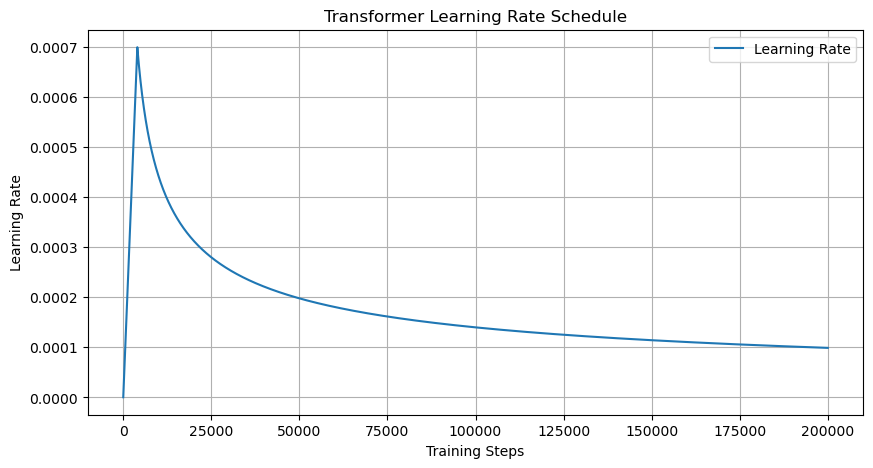

In [23]:
# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# Optimizer 정의
optimizer = optim.AdamW(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [25]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')

model = model.to(device)

In [26]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [27]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

In [28]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=25,
    device=device
)

[Epoch 1, Step 0] Loss: 9.1905, Acc: 0.0000
[Epoch 1, Step 100] Loss: 9.1116, Acc: 0.0000
Epoch 1 Completed - Avg Loss: 9.1510, Avg Acc: 0.0001
[Epoch 2, Step 0] Loss: 9.1543, Acc: 0.0000
[Epoch 2, Step 100] Loss: 9.0896, Acc: 0.0000
Epoch 2 Completed - Avg Loss: 9.1056, Avg Acc: 0.0001
[Epoch 3, Step 0] Loss: 9.0767, Acc: 0.0000
[Epoch 3, Step 100] Loss: 9.0173, Acc: 0.0000
Epoch 3 Completed - Avg Loss: 9.0157, Avg Acc: 0.0002
[Epoch 4, Step 0] Loss: 8.9663, Acc: 0.0000
[Epoch 4, Step 100] Loss: 8.8303, Acc: 0.0072
Epoch 4 Completed - Avg Loss: 8.8811, Avg Acc: 0.0009
[Epoch 5, Step 0] Loss: 8.8055, Acc: 0.0023
[Epoch 5, Step 100] Loss: 8.7343, Acc: 0.0224
Epoch 5 Completed - Avg Loss: 8.6997, Avg Acc: 0.0386
[Epoch 6, Step 0] Loss: 8.5830, Acc: 0.1077
[Epoch 6, Step 100] Loss: 8.4536, Acc: 0.1609
Epoch 6 Completed - Avg Loss: 8.4757, Avg Acc: 0.1578
[Epoch 7, Step 0] Loss: 8.2634, Acc: 0.2260
[Epoch 7, Step 100] Loss: 8.2127, Acc: 0.2005
Epoch 7 Completed - Avg Loss: 8.2103, Avg Acc:

## 5. 챗봇 성능 테스트 (추론)
- LMS에 나왔던 그리디 서치 이외에 빔 서치, Top-K 샘플링으로 다른 디코딩 전략 테스트
- 레이블 스무딩을 적용해 과적합이나 하나의 답변에 모델이 정착하려고 하는 현상 방지 테스트

In [29]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40


    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [30]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [31]:
sentence = '벌써 12시네'
sentence_generation(model, sentence, sp, device)

입력 : 벌써 12시네
출력 : 좋은 수 있을 거예요.


'좋은 수 있을 거예요.'

In [32]:
sentence = '배고프다.'
sentence_generation(model, sentence, sp, device)

입력 : 배고프다.
출력 : 좋은 수 있을 거예요.


'좋은 수 있을 거예요.'

In [33]:
def beam_search_decoder(model, sentence, tokenizer, device='cpu', beam_width=5, max_len=15):
    """
    빔 서치 디코딩을 수행하는 함수
    :param model: 학습된 트랜스포머 모델
    :param sentence: 입력 문장 (string)
    :param tokenizer: 학습된 SentencePiece 토크나이저
    :param device: 실행 디바이스
    :param beam_width: 빔의 크기 (후보 수)
    :param max_len: 생성할 문장의 최대 길이
    :return: 생성된 문장의 토큰 ID 리스트
    """
    model.eval()  # 모델을 평가 모드로 설정

    # --- 입력 문장 전처리 ---
    preprocessed_sentence = preprocess_sentence(sentence)

    # --- 인코더 준비 ---
    enc_input_ids = [tokenizer.bos_id()] + tokenizer.encode(preprocessed_sentence) + [tokenizer.eos_id()]
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # --- 빔 서치 시작 ---
    # 빔(beam)은 (시퀀스, 누적 점수)의 튜플 리스트로 구성됩니다.
    # 점수는 로그 확률(log probability)을 사용하며, 높을수록 좋습니다.
    initial_beam = ([tokenizer.bos_id()], 0.0)
    beams = [initial_beam]

    with torch.no_grad():
        for _ in range(max_len):
            all_candidates = [] # 이번 스텝의 모든 후보군을 저장할 리스트

            # 현재 빔에 있는 각 후보 시퀀스에 대해 다음 토큰을 예측
            for seq, score in beams:
                # 마지막 토큰이 EOS이면, 해당 시퀀스는 완료된 것으로 간주
                if seq[-1] == tokenizer.eos_id():
                    all_candidates.append((seq, score))
                    continue

                # 디코더 입력 준비
                dec_input = torch.tensor([seq], dtype=torch.long, device=device)

                # 모델 예측
                logits = model(enc_input, dec_input)
                last_step_logits = logits[:, -1, :] # 마지막 스텝의 로짓만 사용
                log_probs = F.log_softmax(last_step_logits, dim=-1) # 로짓을 로그 확률로 변환

                # 확률이 높은 상위 beam_width개의 토큰과 그 확률을 가져옴
                top_log_probs, top_ids = torch.topk(log_probs, beam_width, dim=-1)

                # 새로운 후보 시퀀스 생성
                for i in range(beam_width):
                    next_token_id = top_ids[0][i].item()
                    next_token_log_prob = top_log_probs[0][i].item()

                    # 새로운 시퀀스와 누적 점수 계산
                    new_seq = seq + [next_token_id]
                    new_score = score + next_token_log_prob
                    all_candidates.append((new_seq, new_score))

            # --- 빔 업데이트 ---
            # 모든 후보들을 누적 점수(로그 확률) 기준으로 내림차순 정렬
            sorted_candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)

            # 가장 점수가 높은 상위 beam_width개의 후보만 새로운 빔으로 선택
            beams = sorted_candidates[:beam_width]

            # 모든 빔이 EOS로 끝났으면 종료
            if all(seq[-1] == tokenizer.eos_id() for seq, _ in beams):
                break

    # 최종적으로 가장 점수가 높은 시퀀스를 반환
    best_seq, _ = beams[0]
    return best_seq


def sentence_generation_beam_search(model, sentence, tokenizer, device='cpu', beam_width=5):
    """빔 서치 결과를 사람이 읽을 수 있는 문장으로 변환하는 래퍼 함수"""

    output_seq = beam_search_decoder(
        model, sentence, tokenizer, device=device, beam_width=beam_width
    )

    # 시작 토큰(BOS)은 제외하고 디코딩
    predicted_sentence = tokenizer.decode(output_seq[1:])

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

# --- 테스트 ---
print("--- Greedy Search 결과 (비교용) ---")
sentence_generation(model, '벌써 12시네', sp, device)
sentence_generation(model, '배고프다.', sp, device)

print("\n--- Beam Search 결과 (beam_width=5) ---")
sentence_generation_beam_search(model, '벌써 12시네', sp, device, beam_width=5)
sentence_generation_beam_search(model, '배고프다.', sp, device, beam_width=5)

--- Greedy Search 결과 (비교용) ---
입력 : 벌써 12시네
출력 : 좋은 수 있을 거예요.
입력 : 배고프다.
출력 : 좋은 수 있을 거예요.

--- Beam Search 결과 (beam_width=5) ---
입력 : 벌써 12시네
출력 : 좋은 수 있을 거예요.
입력 : 배고프다.
출력 : 좋은.


'좋은.'

In [34]:
from torch.utils.data import random_split

# 데이터셋 생성
full_dataset = ChatbotDataset(csv_file_path, sp, max_length=15)

# 데이터셋 90%(훈련)와 10%(검증) 분할
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 데이터로더 생성
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"총 샘플 수: {len(full_dataset)}개")
print(f"훈련 샘플 수: {len(train_dataset)}개")
print(f"검증 샘플 수: {len(val_dataset)}개")


# 검증을 위한 함수 정의
def evaluate_step(model, batch, loss_function, device):
    model.eval()  # 모델을 평가 모드로 설정

    enc_input, dec_input, target = [x.to(device) for x in batch]

    with torch.no_grad():
        logits = model(enc_input, dec_input)
        loss = loss_function(logits.permute(0, 2, 1), target)
        acc = accuracy_function(logits, target, pad_id=sp.pad_id())

    return loss.item(), acc


# 훈련 및 검증을 수행하는 함수 정의
def train_and_validate(model, train_loader, val_loader, optimizer, loss_function, scheduler,
num_epochs, device):
    model.to(device)

    best_val_loss = float('inf') # 가장 낮은 검증 손실을 저장하기 위한 변수

    for epoch in range(num_epochs):
        # --- 훈련 루프 ---
        model.train() # 훈련 모드
        total_train_loss, total_train_acc = 0, 0
        for batch in train_loader:
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_train_loss += loss
            total_train_acc += acc
            scheduler.step() # 스텝마다 스케줄러 업데이트

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_acc / len(train_loader)

        # --- 검증 루프 ---
        model.eval() # 평가 모드
        total_val_loss, total_val_acc = 0, 0
        for batch in val_loader:
            loss, acc = evaluate_step(model, batch, loss_function, device)
            total_val_loss += loss
            total_val_acc += acc

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_acc / len(val_loader)

        # --- 에폭 결과 출력 ---
        print(f"[Epoch {epoch+1:03d}] "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

        # 가장 좋은 성능의 모델 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"  -> Best model saved with val_loss: {best_val_loss:.4f}")


# 모델 및 옵티마이저 등 재정의 후 학습 시작
# 하이퍼파라미터
NUM_LAYERS = 4
D_MODEL = 512
NUM_HEADS = 8
UNITS = 1024
DROPOUT = 0.1
VOCAB_SIZE = 8000

# 모델, 옵티마이저, 스케줄러, 손실함수
model = Transformer(VOCAB_SIZE, NUM_LAYERS, UNITS, D_MODEL, NUM_HEADS, DROPOUT)
optimizer = optim.AdamW(model.parameters(), betas=(0.9, 0.98), eps=1e-9)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000
))
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

# 학습 시작
EPOCHS = 200
train_and_validate(model, train_dataloader, val_dataloader, optimizer, loss_function, scheduler,
EPOCHS, device)

총 샘플 수: 11638개
훈련 샘플 수: 10474개
검증 샘플 수: 1164개
[Epoch 001] Train Loss: 9.2106, Train Acc: 0.0001 | Val Loss: 9.1978, Val Acc: 0.0000
  -> Best model saved with val_loss: 9.1978
[Epoch 002] Train Loss: 9.1739, Train Acc: 0.0001 | Val Loss: 9.1386, Val Acc: 0.0000
  -> Best model saved with val_loss: 9.1386
[Epoch 003] Train Loss: 9.0977, Train Acc: 0.0001 | Val Loss: 9.0400, Val Acc: 0.0000
  -> Best model saved with val_loss: 9.0400
[Epoch 004] Train Loss: 8.9849, Train Acc: 0.0003 | Val Loss: 8.9025, Val Acc: 0.0002
  -> Best model saved with val_loss: 8.9025
[Epoch 005] Train Loss: 8.8348, Train Acc: 0.0028 | Val Loss: 8.7265, Val Acc: 0.0117
  -> Best model saved with val_loss: 8.7265
[Epoch 006] Train Loss: 8.6489, Train Acc: 0.0563 | Val Loss: 8.5136, Val Acc: 0.1592
  -> Best model saved with val_loss: 8.5136
[Epoch 007] Train Loss: 8.4307, Train Acc: 0.1806 | Val Loss: 8.2672, Val Acc: 0.2312
  -> Best model saved with val_loss: 8.2672
[Epoch 008] Train Loss: 8.1779, Train Acc: 0

In [35]:
# 1. 새로운 모델 객체를 생성 (동일한 구조)
best_model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

# 2. 저장된 최고 성능의 가중치('best_model.pth')를 불러오기
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)

# 답변 생성 테스트
print("--- Greedy Search 결과 (비교용) ---")
sentence_generation(best_model, '벌써 12시네', sp, device)
sentence_generation(best_model, '가족있어?', sp, device)
sentence_generation(best_model, '초조하다.', sp, device)
sentence_generation(best_model, '놀러가고 싶다.', sp, device)
sentence_generation(best_model, '나만 사랑하고 있는건 아니겠지?', sp, device)

print("\n--- Beam Search 결과 (beam_width=5) ---")
sentence_generation_beam_search(best_model, '벌써 12시네', sp, device, beam_width=5)
sentence_generation_beam_search(best_model, '가족있어?', sp, device, beam_width=5)
sentence_generation_beam_search(best_model, '초조하다.', sp, device, beam_width=5)
sentence_generation_beam_search(best_model, '놀러가고 싶다.', sp, device, beam_width=5)
sentence_generation_beam_search(best_model, '나만 사랑하고 있는건 아니겠지?', sp, device, beam_width=5)

/var/folders/14/wm3n_r1s01jfgw6n8j7pr4740000gn/T/ipykernel_11986/540550193.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_m

--- Greedy Search 결과 (비교용) ---
입력 : 벌써 12시네
출력 : 좋은 수 있을 거예요.
입력 : 가족있어?
출력 : 좋은 수 있을 거예요.
입력 : 초조하다.
출력 : 좋은 더 많이 거예요.
입력 : 놀러가고 싶다.
출력 : 좋은.
입력 : 나만 사랑하고 있는건 아니겠지?
출력 : 좋은 사람 거예요.

--- Beam Search 결과 (beam_width=5) ---
입력 : 벌써 12시네
출력 : 잘 거예요.
입력 : 가족있어?
출력 : 잘 거예요.
입력 : 초조하다.
출력 : 잘 거예요.
입력 : 놀러가고 싶다.
출력 : 잘 거예요.
입력 : 나만 사랑하고 있는건 아니겠지?
출력 : 잘 거예요.


'잘 거예요.'

In [36]:
def top_k_sampling_decoder(model, sentence, tokenizer, device='cpu', top_k=50, max_len=15):
    """
    Top-K 샘플링 디코딩을 수행하는 함수
    :param top_k: 샘플링에 사용할 상위 K개 토큰
    """
    model.eval()

    # 전처리
    preprocessed_sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    # 시작 토큰(BOS)과 종료 토큰(EOS)을 추가
    enc_input_ids = [tokenizer.bos_id()] + tokenizer.encode(preprocessed_sentence) + [tokenizer.eos_id()]
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력은 시작 토큰(BOS)만 포함
    dec_input = torch.tensor([[tokenizer.bos_id()]], dtype=torch.long, device=device)

    with torch.no_grad():
        for _ in range(max_len):
            logits = model(enc_input, dec_input)
            last_step_logits = logits[:, -1, :]

            # --- Top-K 샘플링 로직 ---
            # 1. top_k 이외의 토큰에는 아주 낮은 값(-inf)을 주어 확률을 0으로 만듦
            indices_to_remove = last_step_logits < torch.topk(last_step_logits, top_k)[0][..., -1, None]
            last_step_logits[indices_to_remove] = -float('Inf')

            # 2. softmax를 통해 확률 분포로 변환
            probs = F.softmax(last_step_logits, dim=-1)

            # 3. multinomial 샘플링으로 다음 토큰을 '뽑음'
            predicted_id = torch.multinomial(probs, num_samples=1)

            # 종료 토큰이면 중단
            if predicted_id.item() == tokenizer.eos_id():
                break

            # 예측된 토큰을 디코더 입력에 추가
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    return dec_input.squeeze(0).tolist()


def sentence_generation_sampling(model, sentence, tokenizer, device='cpu', top_k=50):
    """Top-K 샘플링 결과를 문장으로 변환하는 래퍼 함수"""

    output_seq = top_k_sampling_decoder(
        model, sentence, tokenizer, device=device, top_k=top_k
    )

    predicted_sentence = tokenizer.decode(output_seq[1:])

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

# --- 테스트 ---
print("--- Top-K Sampling 결과 (top_k=50) ---")
sentence_generation_sampling(best_model, '벌써 12시네', sp, device, top_k=50)
sentence_generation_sampling(best_model, '배고프다.', sp, device, top_k=50)
sentence_generation_sampling(best_model, '오늘 날씨 어때?', sp, device, top_k=50)
sentence_generation_sampling(best_model, '나만 사랑하고 있는건 아니겠지?', sp, device, top_k=50)

--- Top-K Sampling 결과 (top_k=50) ---
입력 : 벌써 12시네
출력 : 좋은 마세요.
입력 : 배고프다.
출력 : 충분히가길 생각해요.
입력 : 오늘 날씨 어때?
출력 : 한 해보세요.
입력 : 나만 사랑하고 있는건 아니겠지?
출력 : 저도 수 있어요.


'저도 수 있어요.'

In [37]:
# 에폭 다시 늘려서 밤 사이 켜놓고 잘 테스트 시작
print("--- 데이터 로딩 시작 ---")
MAX_LENGTH = 15
BATCH_SIZE = 64
csv_file_path = 'data/ChatbotData.csv'

# 데이터셋 생성
original_dataset = ChatbotDataset(csv_file_path, sp, max_length=MAX_LENGTH)

train_size = int(0.9 * len(original_dataset))
val_size = len(original_dataset) - train_size
train_dataset, val_dataset = random_split(original_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"훈련: {len(train_dataset)}개, 검증: {len(val_dataset)}개")


# 얼리 스토핑 기능 추가
def final_train_and_validate(model, train_loader, val_loader, optimizer, loss_function,
scheduler, num_epochs, device, patience=10):
    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0 # 얼리 스토핑 카운터

    print("\n--- 학습 시작 ---")
    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_train_acc = 0, 0
        for batch in train_loader:
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_train_loss += loss
            total_train_acc += acc
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_acc / len(train_loader)

        model.eval()
        total_val_loss, total_val_acc = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                loss, acc = evaluate_step(model, batch, loss_function, device)
                total_val_loss += loss
                total_val_acc += acc

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_acc / len(val_loader)

        print(f"[Epoch {epoch+1:03d}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

        # 얼리 스토핑
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model_final.pth')
            print(f"  -> Best model saved with val_loss: {best_val_loss:.4f}")
            patience_counter = 0 # 카운터 리셋
        else:
            patience_counter += 1
            print(f"  -> Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break # 학습 중단

# 하이퍼파라미터 설정
NUM_LAYERS = 6
D_MODEL = 512
NUM_HEADS = 8
UNITS = 1024
DROPOUT = 0.1
VOCAB_SIZE = sp.GetPieceSize()

model = Transformer(VOCAB_SIZE, NUM_LAYERS, UNITS, D_MODEL, NUM_HEADS, DROPOUT)
optimizer = optim.AdamW(model.parameters(), betas=(0.9, 0.98), eps=1e-9)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

# 학습 실행
EPOCHS = 400
PATIENCE = 10

final_train_and_validate(
    model, train_dataloader, val_dataloader,
    optimizer, loss_function, scheduler,
    EPOCHS, device, PATIENCE
)

--- 데이터 로딩 시작 ---
훈련: 10474개, 검증: 1164개

--- 학습 시작 ---
[Epoch 001/400] Train Loss: 9.0623, Acc: 0.0001 | Val Loss: 9.0428, Val Acc: 0.0000
  -> Best model saved with val_loss: 9.0428
[Epoch 002/400] Train Loss: 9.0021, Acc: 0.0000 | Val Loss: 8.9458, Val Acc: 0.0000
  -> Best model saved with val_loss: 8.9458
[Epoch 003/400] Train Loss: 8.8811, Acc: 0.0004 | Val Loss: 8.7857, Val Acc: 0.0005
  -> Best model saved with val_loss: 8.7857
[Epoch 004/400] Train Loss: 8.7045, Acc: 0.0194 | Val Loss: 8.5666, Val Acc: 0.0945
  -> Best model saved with val_loss: 8.5666
[Epoch 005/400] Train Loss: 8.4739, Acc: 0.1510 | Val Loss: 8.2959, Val Acc: 0.2353
  -> Best model saved with val_loss: 8.2959
[Epoch 006/400] Train Loss: 8.1980, Acc: 0.2442 | Val Loss: 7.9884, Val Acc: 0.2706
  -> Best model saved with val_loss: 7.9884
[Epoch 007/400] Train Loss: 7.8950, Acc: 0.2702 | Val Loss: 7.6660, Val Acc: 0.2815
  -> Best model saved with val_loss: 7.6660
[Epoch 008/400] Train Loss: 7.5899, Acc: 0.2817 |

In [38]:
# 최종 모델을 저장하기 위한 객체 생성
best_model_final = Transformer(                                                                             
    vocab_size=VOCAB_SIZE,                                                                            
    num_layers=NUM_LAYERS,                                                                            
    units=UNITS,                                                                                      
    d_model=D_MODEL,                                                                                  
    num_heads=NUM_HEADS,                                                                              
    dropout=DROPOUT                                                                                   
)                                                                                                     
                                                                                                    
# 저장된 가중치를 불러오기
best_model_final.load_state_dict(torch.load('best_model_final.pth'))                                              
best_model_final.to(device)

# 답변 생성을 위한 래퍼 함수                                                                          
def generate_answer(model, sentence, tokenizer, device, decoding_strategy='sampling',                 
beam_width=5, top_k=50):                                                                              
    if decoding_strategy == 'greedy':                                                                 
        output_seq = decoder_inference(model, sentence, tokenizer, device)                               
    elif decoding_strategy == 'beam':                                                                 
        output_seq = beam_search_decoder(model, sentence, tokenizer, device, beam_width=beam_width)                                                                                
    elif decoding_strategy == 'sampling':                                                             
        output_seq = top_k_sampling_decoder(model, sentence, tokenizer, device, top_k=top_k)                                                                                          
    else:                                                                                             
        raise ValueError("Unknown decoding strategy")                                                 
                                                                                                    
    predicted_sentence = tokenizer.decode(output_seq[1:-1]) # BOS, EOS 제외                           
                                                                                                    
    print(f"입력: {sentence}")                                                                        
    print(f"답변 ({decoding_strategy}): {predicted_sentence}")                                        
    print('---')                                                                                      
    return predicted_sentence                                                                         

# 여러 문장과 디코딩 전략으로 테스트                                                                  
test_sentences = ["벌써 12시네", "배고프다.", "오늘 날씨 어때?", "나만 사랑하고 있는건 아니겠지?", "영화 추천해줘", 
                  "헤어지자고 말하는게 나을까?", "제주도로 여행가고 싶어", "요즘 기분이 우울해", "친구랑 싸웠어", "취업 준비는 어떻게 해야 할까?"]                                                                          
                                                                                                    
for sentence in test_sentences:                                                                       
    generate_answer(best_model_final, sentence, sp, device, decoding_strategy='greedy')                     
    generate_answer(best_model_final, sentence, sp, device, decoding_strategy='beam', beam_width=5)                                                                                         
    generate_answer(best_model_final, sentence, sp, device, decoding_strategy='sampling', top_k=50)                                                                                             
    print('\n=====================================\n')

/var/folders/14/wm3n_r1s01jfgw6n8j7pr4740000gn/T/ipykernel_11986/3089516203.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_final.load_state_dict(torch.load(

입력: 벌써 12시네
답변 (greedy): 좋은 사람 잘 될 거예요
---
입력: 벌써 12시네
답변 (beam): 잘 될 거예요.
---
입력: 벌써 12시네
답변 (sampling): 저도 사람 만날 수 있어요
---


입력: 배고프다.
답변 (greedy): 
---
입력: 배고프다.
답변 (beam): 잘 될 거예요.
---
입력: 배고프다.
답변 (sampling): 그럴 수 있어요
---


입력: 오늘 날씨 어때?
답변 (greedy): 좋은 사람 거예요
---
입력: 오늘 날씨 어때?
답변 (beam): 잘 될 거예요.
---
입력: 오늘 날씨 어때?
답변 (sampling): 사람일 거예요
---


입력: 나만 사랑하고 있는건 아니겠지?
답변 (greedy): 잘 될 거예요
---
입력: 나만 사랑하고 있는건 아니겠지?
답변 (beam): 잘 될 거예요.
---
입력: 나만 사랑하고 있는건 아니겠지?
답변 (sampling): 많이 안 될 거예요
---


입력: 영화 추천해줘
답변 (greedy): 좋은 사람 잘 될 거예요
---
입력: 영화 추천해줘
답변 (beam): 잘 될 거예요.
---
입력: 영화 추천해줘
답변 (sampling): 잘
---


입력: 헤어지자고 말하는게 나을까?
답변 (greedy): 좋은 사람 잘 될 거예요
---
입력: 헤어지자고 말하는게 나을까?
답변 (beam): 잘 될 거예요.
---
입력: 헤어지자고 말하는게 나을까?
답변 (sampling): 천천히 것 같아요
---


입력: 제주도로 여행가고 싶어
답변 (greedy): 좋은 사람 잘 될 거예요
---
입력: 제주도로 여행가고 싶어
답변 (beam): 잘 될 거예요.
---
입력: 제주도로 여행가고 싶어
답변 (sampling): 마음서 말해보세요
---


입력: 요즘 기분이 우울해
답변 (greedy): 좋은 사람 잘 될 거예요
---
입력: 요즘 기분이 우울해
답변 (beam): 잘 될 거예요.
---
입력: 요즘 기분이 우울해
답변 (s

In [39]:
# --- 레이블 스무딩을 적용한 최종 학습 코드 ---

# 1. 데이터셋 및 데이터로더 준비 (이전과 동일)
print("--- 데이터 로딩 시작 ---")
MAX_LENGTH = 15
BATCH_SIZE = 64
csv_file_path = 'data/ChatbotData.csv'

dataset = ChatbotDataset(csv_file_path, sp, max_length=MAX_LENGTH)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"훈련: {len(train_dataset)}개, 검증: {len(val_dataset)}개")


# 2. 모델 및 관련 요소 정의
NUM_LAYERS = 6
D_MODEL = 512
NUM_HEADS = 8
UNITS = 1024
DROPOUT = 0.1
VOCAB_SIZE = sp.GetPieceSize()

model = Transformer(VOCAB_SIZE, NUM_LAYERS, UNITS, D_MODEL, NUM_HEADS, DROPOUT)
optimizer = optim.AdamW(model.parameters(), betas=(0.9, 0.98), eps=1e-9)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000
))

# --- 여기가 핵심: 레이블 스무딩 적용 ---
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id(), label_smoothing=0.1)
print('레이블 스무딩(0.1)이 적용된 손실 함수를 사용')
# ------------------------------------

# 3. 학습 실행 (train_and_validate 함수는 이전과 동일)
EPOCHS = 100 # 경향을 보기 위해 100으로 설정
PATIENCE = 5   # 조기 종료 patience

final_train_and_validate(
    model, train_dataloader, val_dataloader,
    optimizer, loss_function, scheduler,
    EPOCHS, device, PATIENCE
)

# 4. 학습 완료 후 최고 성능 모델로 테스트
print('학습 완료! 최고 성능 모델로 테스트 시작')
best_model = Transformer(VOCAB_SIZE, NUM_LAYERS, UNITS, D_MODEL, NUM_HEADS, DROPOUT)
best_model.load_state_dict(torch.load('best_model_final.pth')) # 파일 이름은 이전과 동일하게 사용
best_model.to(device)

test_sentences = ["배고프다.", "오늘 날씨 어때?", "영화 추천해줘", "요즘 기분이 우울해"]
for sentence in test_sentences:
    sentence_generation_sampling(best_model, sentence, sp, device, top_k=50)

--- 데이터 로딩 시작 ---
훈련: 10474개, 검증: 1164개
레이블 스무딩(0.1)이 적용된 손실 함수를 사용

--- 학습 시작 ---
[Epoch 001/100] Train Loss: 9.1435, Acc: 0.0001 | Val Loss: 9.1294, Val Acc: 0.0000
  -> Best model saved with val_loss: 9.1294
[Epoch 002/100] Train Loss: 9.0867, Acc: 0.0002 | Val Loss: 9.0349, Val Acc: 0.0000
  -> Best model saved with val_loss: 9.0349
[Epoch 003/100] Train Loss: 8.9719, Acc: 0.0004 | Val Loss: 8.8780, Val Acc: 0.0008
  -> Best model saved with val_loss: 8.8780
[Epoch 004/100] Train Loss: 8.8022, Acc: 0.0153 | Val Loss: 8.6621, Val Acc: 0.0819
  -> Best model saved with val_loss: 8.6621
[Epoch 005/100] Train Loss: 8.5820, Acc: 0.1349 | Val Loss: 8.3946, Val Acc: 0.2195
  -> Best model saved with val_loss: 8.3946
[Epoch 006/100] Train Loss: 8.3195, Acc: 0.2204 | Val Loss: 8.0923, Val Acc: 0.2419
  -> Best model saved with val_loss: 8.0923
[Epoch 007/100] Train Loss: 8.0320, Acc: 0.2367 | Val Loss: 7.7823, Val Acc: 0.2523
  -> Best model saved with val_loss: 7.7823
[Epoch 008/100] Train

/var/folders/14/wm3n_r1s01jfgw6n8j7pr4740000gn/T/ipykernel_11986/726066875.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_m

입력 : 배고프다.
출력 : 너무 있어요.
입력 : 오늘 날씨 어때?
출력 : 하지 것도 할 같아요.
입력 : 영화 추천해줘
출력 : 잘 있어요.
입력 : 요즘 기분이 우울해
출력 : 충분히 거예요.
